In [86]:
# adds the project specific libs to the sys path
import sys
from pathlib import Path

proj_lib_path = str(Path.cwd().parent / 'libs')
if proj_lib_path not in sys.path:
    sys.path.insert(1, proj_lib_path)
    print(f'added {proj_lib_path} to the sys.path')

from supervised1.config import MODEL_DIR, DATA_DIR
import os   

print(f'models area at {MODEL_DIR}')
print(f'data is at {DATA_DIR}')

models area at /Users/n0c09jf/code/github/tryml/projects/supervised1/_models
data is at /Users/n0c09jf/code/github/tryml/projects/supervised1/_data


In [87]:
root_folder = os.path.join(DATA_DIR, 'ensemble')
os.makedirs(root_folder, exist_ok=True)

# Voting Classifiers

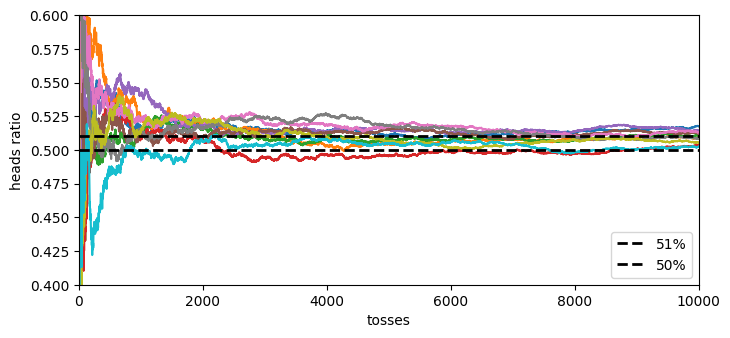

In [88]:
import numpy as np
from matplotlib import pyplot as plt

heads_proba = 0.51

coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cum_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cum_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.50, 0.50], "k--", linewidth=2, label="50%")
plt.xlabel("tosses")
plt.ylabel("heads ratio")
plt.axis([0, 10000, 0.4, 0.6])
plt.legend(loc="lower right")
plt.show()

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import  make_moons

X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier([('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [91]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


VotingClassifer does better with the hard voting configuration as  dataset is generated with head probability of 0.51. 

Hard voting is assigning a absolution classification scrore to model output. In cat/dog prediction and if cat prediction is 0.51 it makes it as 1 where as soft voting it keeps as is. In general soft voting preserve information and does better.

another example:  three ppl voting for cand a or b. two of them vote 0.51 for a and other vote 0 for a. \
In hard voting - 1, 1, 0 and candidate a wins \
In soft voting - avg(0.51, 0.51, 0) = 0.34 and candidate b wins

In [92]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier([('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging Ensembles

In [93]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print("Bagging classifier", accuracy_score(y_test, y_pred))

dt_clf = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print("decision tree classifier", accuracy_score(y_test, y_pred))

Bagging classifier 0.904
decision tree classifier 0.856


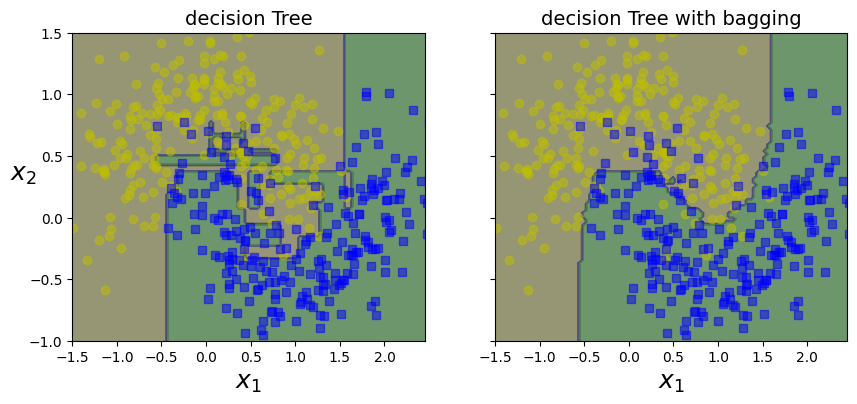

In [94]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contourf(x1, x2, y_pred, alpha=0.8, cmap=custom_cmap2)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(dt_clf, X, y)
plt.title("decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("decision Tree with bagging", fontsize=14)
plt.ylabel("")
plt.show()

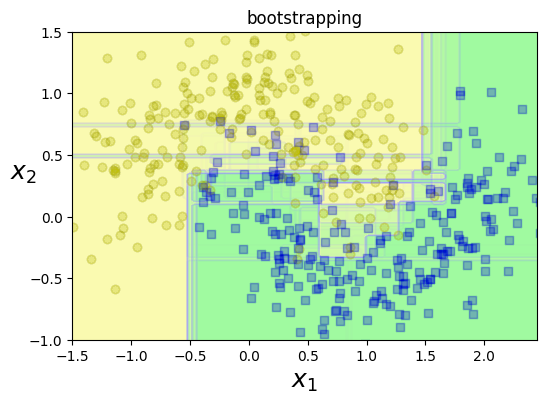

In [95]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))

    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])

    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.title('bootstrapping')
plt.show()

# Random Forests

In [96]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
    n_estimators=500,
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_rf))
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.912 0.912


1.0

## Feature importance with Random Forest

In [97]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876378
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.42335799635476823


## Out of Bag evaluation



In [98]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, bootstrap=True, oob_score=True,
    random_state=40
)
bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8986666666666666


0.912

OOB scoring, like cross validation, is a way to measure error (without need for a separate validation dataset) in a more clever and comprehensive way than a simple acuracy score. OOB scoring is not always necessary, but its important to understand what it is, especially because it reinforces our understanding of how bagging works.

## Feature Importance

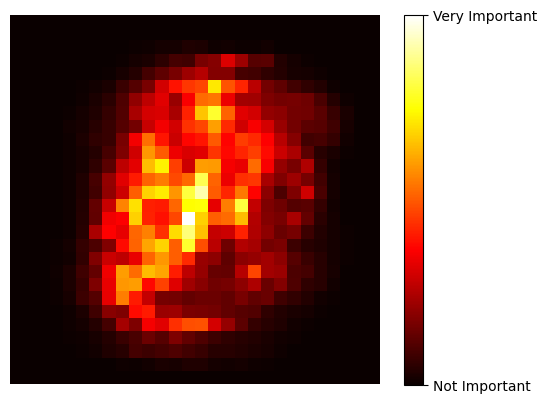

In [70]:
from sklearn.datasets import fetch_openml
import matplotlib as mlp

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mlp.cm.hot, interpolation='nearest')
    plt.axis('off')

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', 'Very Important'])
plt.show()

# AdaBoost

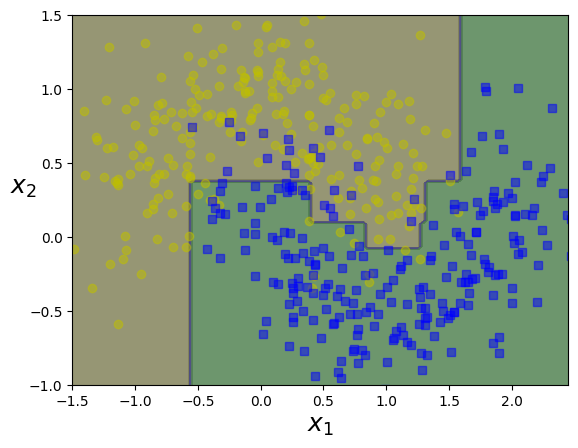

In [99]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME', learning_rate=0.5, random_state=42
)

ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)


In [ ]:
m = len(X_train)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
